# 4. 좋은 훈련 세트 만들기: 데이터 전처리

- 데이터셋이서 누락된 값을 제거하거나 대체하기
- 머신 러닝 알고리즘을 위해 범주형 데이터 변환하기
- 모델과 관련이 높은 특성 선택하기

## 4.1 누락된 데이터 다루기

일반적으로 누락된 값은 데이터 테이블에 빈 공간이나 예약된 문자열로 채워진다  
숫자가 아니라는 의미(not a number)NaN이나 NULL(관계형 데이터베이스에서 모르는 값을 지칭하는데 주로 사용)과 같은 값을 사용한다  
안타깝게도 대부분의 수치 계산 라이브러리는 누락된 값을 다룰 수 없거나 단순히 이를 무시했을 때 예상치 못한 결과를 만든다  

### 4.1.1 테이블 형태 데이터에서 누락된 값 식별

In [1]:
import pandas as pd
from io import StringIO

csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''
df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


StringIO를 이용하면 하드 디스크에 있는 일반 CSV파일 처럼 data_csv에 저장된 문자열을 읽어 pandas DataFrame으로 변환할 수 있다  
아주 큰 DataFrame일 경우 수동으로 누락된 값을 찾는 것은 매우 번거롭다  
isnull method는 cell이 수치 값을 담고 있는지(False)또는 누락되어 있는지(True)를 나타내는 boolean 값이 채워진 DataFrame을 반환한다  

In [2]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

이런 식으로 열마다 누락된 값의 개수를 알 수 있다  

사이킷런의 추정기에 주입하기 전에 values 속성을 사용하여 언제나 numpy array를 얻을 수 있다

In [3]:
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

### 4.1.2 누락된 값이 있는 샘플이나 특성 제외

누락된 데이터를 다루는 가장 쉬운 방법 중 하나는 해당 샘플이나 특성을 완전히 삭제하는 것이다  

In [4]:
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


axis 매개변수를 1로 지정해서 NaN이 하나라도 있는 열을 삭제할 수 있다

In [5]:
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


dropa method는 몇 가지 편리한 매개변수를 제공한다

In [6]:
# 모든 열이 NaN일 때만 행을 삭제한다
# (여기서는 모든 값이 NaN인 행이 없기 때문에 전체 배열이 반환된다)
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [7]:
#실수 값이 4개보다 작은 행을 삭제한다
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [8]:
#특정 열에 NaN이 있는 행만 삭제한다
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


너무 많은 데이터를 제거하면 안정된 분석이 불가능할 수 있다  
너무 많은 특성 열을 제거하면 분류기가 클래스를 구분하는 데 필요한 중요한 정보를 잃을 위험이 있다  

### 4.1.3 누락된 값 대체

보간 기법을 사용하여 데이터셋에 있는 다른 훈련샘플로부터 누락된 값을 추정할 수 있다  
가장 흔한 보간 기법 중 하나는 평균으로 대체하는 것이다  
각 특성 열의 전체 평균으로 누락된 값을 바꾸는 것이다  

In [9]:
from sklearn.preprocessing import Imputer
imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

C:\Users\ukida\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

axis = 0을 axis = 1로 바꾸면 행의 평균이 계산된다  
strategy 매개변수에 설정할 수 있는 다른 값은 median(데이터를 순서대로 나열했을 떄 중간에 위치한 값), most_frequent(가장 많이 나타난 값)으로 누락된 값을 대체한다

### 4.1.4 사이킷런 추정기 API 익히기

Imputer 클래스는 데이터 변환에 사용되는 사이킷런의 transform 클래스다  
이런 추정기의 주요 method 두개는 fit과 transform이다  
fit method를  사용하여 훈련 데이터에서 모델 parmeter을 학습한다  
transform method를 사용하여 학습한 parmeter로 데이터를 변환한다  
변환하려는 데이터의 배열은 모델 학습에 사용된 데이터의 특성 개수와 같아야한다  

<img src='https://thebook.io/img/007022/p141.jpg'>

<img src='https://thebook.io/img/007022/p142.jpg'>

## 4.2 범주형 데이터 다루기

실제 데이터셋은 하나 이상의 범주형 특성이 포함된 경우가 많다  

### 4.2.1 순서가 있는 특성과 순서가 없는 특성

순서가 있는 특성은 정렬하거나 차례대로 놓을 수 있으므로 범주형 특성이다. ex)티셔츠 사이즈  
순서가 없는 특성은 차례를 부여할 수 없다. ex)티셔츠 컬러  

$\boldsymbol{ 예제 데이터셋 만들기}$

In [10]:
import pandas as pd
df = pd.DataFrame([
                  ['green', 'M', 10.1, 'class1'],
                  ['red', 'L', 13.5, 'class2'], 
                  ['blue', 'XL', 15.3, 'class1']])
df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


### 4.2.2 순서 특성 매핑

학습 알고리즘이 순서 특성을 올바르게 인식하려면 범주형의 문자열 값을 정수로 바꾸어야 한다  
안타깝지만 size 특성의 순서를 올바르게 자동으로 바꾸어 주는 함수는 없기 때문에 매핑 함수를 직접 만들어야 한다  
여기서는 특성 간의 산술적인 차이를 이미 알고 있다 가정한다  
ex)
$$
XL=L + 1 = M + 2
$$

In [11]:
size_mapping = {
                'XL': 3,
                'L': 2,
                'M': 1}
df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


만약 나중에 정수 값을 다시 원래 문자열 표현으로 바꾸고 싶다면 간단히 거꾸로 매핑하는 딕셔너리 inv_size_mapping={v: k for k, v in size_mapping.items()}를 정의하면 된다  
size_mapping 딕셔너리와 비슷하게 pandas의 map method를 사용하여 변환된 특성 열에 적용할 수 있다

In [12]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

### 4.2.3 클래스 레이블 인코딩

사이킷런의 분류 추정기 대부분은 자체적으로 클래스 레이블을 정수로 변환해 주지만 사소한 실수를 방지하기 위해 클래스 레이블을 정수 배열로 전달하는 것이 좋다  
특정 문자열 레이블에 할당한 정수는 아무런 의미가 없다  
emumerate를 사용하여 클래스 레이블을 0부터 할당한다

In [13]:
import numpy as np
class_mapping = {label: idx for idx, label in
                 enumerate(np.unique(df['classlabel']))}
class_mapping

{'class1': 0, 'class2': 1}

그 다음 매핑 딕셔너리를 사용하여 class label을 정수로 변환한다

In [14]:
df['classlabel'] = df['classlabel'].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,0
1,red,2,13.5,1
2,blue,3,15.3,0


매핑 딕셔너리의 키-값 쌍을 뒤집어서 변환된 class label을 다시 원본 문자열로 바꿀 수 있다  

In [15]:
inv_class_mapping = {v: k for k, v in class_mapping.items()}
df['classlabel'] = df['classlabel'].map(inv_class_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


다른 방법으로 사이킷런에 구현된 LabelEncoder class를 사용하면 편리하다

In [16]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()
y = class_le.fit_transform(df['classlabel'].values)
y

array([0, 1, 0])

inverse_transform method를 사용하면 정수 클래스 레이블을 원본 문자열 형태로 되돌릴 수 있다  

In [17]:
class_le.inverse_transform(y)

array(['class1', 'class2', 'class1'], dtype=object)

### 4.2.4 순서가 없는 특성에 원-핫 인코딩 적용

In [18]:
X = df[['color', 'size', 'price']].values
color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

Numpy 배열X의 첫번 째 열은 다음과 같은 color 값을 갖는다

- blue = 0  
- green = 1  
- red = 2  



컬러 값에는 순서가 없지만 학습 알고리즘은 순서가 있다고 가정할 것이다  
이 가정이 옳지 않지만 알고리즘이 의미 있는 결과를 만들 수 있다  
하지만 이 결과가 최선은 아닐 것이다  
이 문제를 해결하기 위한 통상적인 방법은 one-hot encoding 기법이다  
이방식의 아이디어는 순서 없는 특성에 들어 있는 고유한 값마다 새로운 더미(dummy)특성을 만드는 것이다  
여기서 color의 특성을 세개의 새로운 특성인 blue, green, red로 변환한다  
이진 값을 사용하여 특정 샘플의 color를 나타낸다  
예를 들어 blue샘플은 blue = 1. green = 0, red = 0으로 인코딩 된다  

In [19]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()

C:\Users\ukida\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\ukida\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

원-핫 인코딩으로 더미 변수를 만드는 더 편리한 방법은 판다스의 get_dummies 메서드를 사용하는 것이다  

In [20]:
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


원-핫 인코딩된 데이터셋을 사용할 때 다중 공선성문제를 유념해야한다  
특성 간의 상관관계가 높으면 역행렬을 계산하기 어려워 수치적으로 불안정해진다  
변수 간의 상관관계를 감소하려면 원-핫 인코딩된 배열에서 특성 열 하나를 삭제한다  
이렇게 특성을 삭제해도 잃는 정보는 없다  

get_dummies를 사용할 때 drop_first 매개변수를 True로 지정하여 첫번째 열을 삭제할 수 있다

In [21]:
pd.get_dummies(df[['price', 'color', 'size']],
              drop_first=True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


OneHotEncoder는 열을 삭제하는 매개변수가 없다  
그 대신 다음 코드처럼 간단하게 원-핫 인코딩된 넘파이 배열을 슬라이싱할 수 있다  

In [22]:
ohe = OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()[:, 1:]

C:\Users\ukida\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\ukida\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


array([[ 1. ,  0. ,  1. , 10.1],
       [ 0. ,  1. ,  2. , 13.5],
       [ 0. ,  0. ,  3. , 15.3]])

## 4.3 데이터셋을 훈련 세트와 테스트 세트로 나누기

모델을 실전에 투입하기 전에 테스트 세트에 있는 레이블과 예측을 비교합니다  
이는 편향되지 않은 성능을 측정하기 위해서이다  

In [23]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                     'ml/machine-learning-databases/'
                     'wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol',
                   'Malic acid', 'Ash',
                   'Alcalinity of Ash', 'Magnesium',
                   'Total phenols', 'Flavanoids',
                   'Nonflavanoid phenols',
                   'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines',
                   'Proline']
print('클래스 레이블', np.unique(df_wine['Class label']))

클래스 레이블 [1 2 3]


In [24]:
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of Ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


사이킷런의 model_selection 모듈에 있는 train_test_split 함수를 사용하면 가장 간편하게 데이터셋을 랜덤한 훈련 세트와 테스트 세트로 나눌 수 있다  

In [25]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
                     test_size = 0.3,
                     random_state = 0,
                     stratify = y)

인덱스 1에서 13까지의 특성을 넘파이 배열로 변환하여 변수 X에 할당한다  
첫 번째 열릐 클래스 레이블은 변수 y에 할당한다  
train_test_split 함수를 사용하여 X와 y를 랜덤하게 훈련 세트와 테스트 세트로 분할한다  
와인 샘플의 30%가 테스트 세트에 할당된다  
stratify 매개변수를 사용하여 훈련 세트와 테스트 세트에 있는 클래스 비율이 원본 데이터셋과 동일하게 유지된다

## 4.4 특성 스케일 맞추기

스케일이 다른 특성을 맞추는 대표적인 방법 두가지에는 정규화와 표준화가 있다  
재부분의 정규화는 특성의 스케일을 [0,1] 범위에 맞투는 것이다  
최소-최대 스케일 변환의 특별한 경우이다  
데이터를 정규화하기 위해 각 특성의 열마다 최소-최대 스케일 변환을 적용하여 샘플$x^{\left(i\right)}$에서 새로운 값 $x_{norm}^{\left(i\right)}$을 계산한다  

$$
x_{norm}^{i} = \frac{x^{\left(i\right)} - x_{min}}{x_{max} - x_{min}}
$$

In [26]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.fit_transform(X_test)

최소-최대 스케일 변환을 통한 정규화는 범위가 정해진 값이 필요할 때 유용하게 사용할 수 있는 일반적인 기법이다  
표준화는 많은 머신 러닝 알고리즘, 특히 경사 하강법 같은 최적화 알고리즘에서 널리 사용된다  

로지스틱 회귀와 SVM 같은 여러 선형 모델은 가중치를 0 또는 0에 가까운 작은 난수로 초기화한다  
표준화를 사용하면 특성의 평균을 0에 맞추고 표준편차를 1로 만들어 정규 분포와 같은 특징을 가지도록 만든다  
이는 가중치를 더 쉽게 학습할 수 있도록 만든다  
표준화는 이상치 정보가 유지되기 때문에 제한된 범위로 데이터를 조정하는 최소-최대 스케일 변환에 비해 알고리즘이 이상치에 덜 민감하다  
표준화 공식은 다음과 같다

$$
x_{std}^{\left(i \right)} = \frac{x^{\left(i \right)} - \mu_{x}}{\sigma_{x}}
$$

여기서 $\mu_{x}$는 어떤 특성의 샘플 평균이고 $\sigma_{x}$는 그에 해당하는 표준편차이다  

- 0에서 5까지 숫자로 이루어진 간단한 예시 데이터셋에 표준화와 정규화 두 개의 트성 스케일 변환 기법을 적용한 결과
<img src='https://blog.kakaocdn.net/dn/blnW1w/btqBJ8IjTH6/TfKwXnkRvviJ2cSwscAUpK/img.png'>

In [27]:
ex = np.array([0, 1, 2, 3, 4, 5])
print('표준화:', (ex - ex.mean()) / ex.std())

표준화: [-1.46385011 -0.87831007 -0.29277002  0.29277002  0.87831007  1.46385011]


In [28]:
print('정규화', (ex - ex.min()) / (ex.max() - ex.min()))

정규화 [0.  0.2 0.4 0.6 0.8 1. ]


MinMaxScaler 클래스와 비슷하게 sklearn은 표준화를 위한 클래스도 제공한다

In [29]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

여기서 학습한 파라미터로 테스트 세트와 새로운 데이터 포인트를 모두 변환한다  

## 4.5 유용한 특성 선택

모델이 테스트 세트보다 훈련 세트에서 성능이 높다면 과대적합일 확률이 높다  
새로운 데이터에는 잘 일반화하지 못하기 때문에 모델 분산이 크다  
과대적합의 이유는 주어진 훈련데이터에 비해 모델이 너무 복잡하기 때문이다
일반화 오차를 감소시키기 위해 많이 사용하는 방법은 다음과 같다  

- 더 많은 훈련 데이터를 모은다  
- 규제를 통해 복잡도를 제한한다  
- 파라미터 개수가 적은 간단한 모델을 선택한다  
- 데이터 차원을 줄인다  

### 4.5.1 모델 복잡도 제한을 위한 L1 규제와 L2규제

L2 규제는 개별 가중치 값을 제한하여 모델 복잡도를 줄이는 한 방법이다  
가중치 벡터 $\mathbf{w}$의 L2 규제는 다음과 같이 정의한다
$$
L2:\left \| \mathbf{w}\right \|_{2}^{2} = \sum_{j=1}^{m}w_{j}^{2}
$$

모델 복잡도를 줄이는 또 다른 방법은 L1 규제이다  
$$
L1:\left \| \mathbf{w} \right \|_{1} = \sum_{j=1}^{m}\left|w_{j}\right|
$$

가중치 제곱을 가중치 절댓값으로 바꾼 것이다  
L1 규제는 보통 희소한 특성 벡터를 만든다  
대부분의 특성 가중치가 0이 된다  
실제로 관련 없는 특성이 많은ㄴ 고차원 데이터셋일 경우 이런 희소성이 도움이 될 수 있다  

### 4.5.2 L2 규제의 기하하적 해석

L2 규제는 비용함수에 페널티 항을 추가하여 규제가 업ㄱ는 비용 함수로 훈련한 모델에 비해 가중치 값을 아주 작게 만드는 효과를 낸다  
두 개의 가중치 $w_{1}$ 과 $w_{2}$에 대한 볼록한 비용 함수의 등고선을 그려보면 
<img src='https://thebook.io/img/007022/p156.jpg'>  
규제를 더 작은 가중치를 얻기 위해 비용 함수에 추가하는 페널티 항으로 생각할 수 있다(=큰 가중치를 제한한다)  

규제 파라미터 $\lambda$로 규제의 강도를 크게 하면 가중치가 0에 가까워지고 훈련 데이터에 대한 모델 의존성은 줄어든다  
<img src='https://blog.kakaocdn.net/dn/dyGuce/btqBGYZMrYz/F0pvOmqEzKX63OVwTtWy9K/img.jpg'>
가중치의 값은 규제 예산을 초과할 수 없다. 즉, 가중치 값의 조합이 회색 공 바깥에 놓일 수 없다  
하지만 여전히 비용함수를 최소화해야한다  
페널티 제약이 있는 상황에서 최선은 L2 회색 공과 규제가 없는 비용 함수의 등고선이 만나는 지점이다  
규제 파라미터 $\lambda$가 커질수록 페널티 비용이 빠르게 증가하여 L2공을 작게 만든다  
우리의 목표는 규제가 없는 비용과 페널티 항의 합을 최소화하는 것이다  
이는 모델을 학습할 ㅁ나한 충분한 훈련 데이터가 없을 때 편향을 추가하여 모델을 간단하게 만듦으로써 분산을 줄이는 것으로 해석할 수 있다  

### 4.5.3 L1규제를 사용한 희소성

L1 페널티는 가중치 절댓값의 합이기 때문에 다이아몬드 모양의 제한 범위를 그릴 수 있다  
<img src='https://blog.kakaocdn.net/dn/d4588x/btqBE1DlY0d/b2EpxJlr4TSJOF6sWnbQFK/img.jpg'>
$w_{1}=0$일 때 비용 함수의 등고선이 L1 다이아몬드와 만나는 것을 볼 수 있다  
L1규제의 등고선은 날카롭기 때문에 비용 함수의 포물선과 L1다이아몬드의 경계가 만나는 최적점은 축에 가깝게 위치할 가능성이 높다  
이것이 희소성이 나타나는 이유이다  

사이킷런에서 L1 규제를 지원하는 모델은 penalty 매개변수를 'l1'으로 지정하여 희소한 모델을 만들 수 있다  

In [30]:
from  sklearn.linear_model import LogisticRegression
LogisticRegression(solver='liblinear', multi_class='auto', penalty='l1')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

표준화 전처리된 Wine 데이터에 L1 규제가 있는 로지스틱 회귀를 적용하면 다음과 같은 희소한 모델을 만든다  

In [31]:
lr = LogisticRegression(solver='liblinear', multi_class='auto', penalty='l1',
                        C=1.0, random_state=42)
lr.fit(X_train_std, y_train)
print('훈련 정확도:', lr.score(X_train_std, y_train))

훈련 정확도: 1.0


In [32]:
print('테스트 정확도:', lr.score(X_test_std, y_test))

테스트 정확도: 1.0


훈련과 테스트 정확도를 보면 모델이 두 데이터셋에 완벽하게 작동한다는 것을 알 수 있습니다  
lr.intercept_ 속성으로 절편을 확인해 보면 세개의 값이 들어 있는 배열이 반환된다  

In [33]:
lr.intercept_

array([-1.26356604, -1.21599454, -2.37043523])

LogisticRegression(solver='liblinear', multi_class='auto') 객체를 다중 클래스 데이터셋에 적용하면 기본적으로 OvR방식을 사용한다  
첫번째 절편은 클래스1을 2,3과 구분하는 모델에속한 것이다  

In [34]:
lr.coef_

array([[ 1.24571379,  0.18047746,  0.74447184, -1.16206611,  0.        ,
         0.        ,  1.16544663,  0.        ,  0.        ,  0.        ,
         0.        ,  0.55203518,  2.50981212],
       [-1.53722618, -0.38723608, -0.99490375,  0.36490375, -0.05976457,
         0.        ,  0.66773248,  0.        ,  0.        , -1.9341522 ,
         1.23402387,  0.        , -2.23179839],
       [ 0.13508255,  0.16979104,  0.35787068,  0.        ,  0.        ,
         0.        , -2.43274437,  0.        ,  0.        ,  1.56234781,
        -0.81813588, -0.49713467,  0.        ]])

lr.coef_ 속성에 있는 가중치는 클래스마다 벡터 하나씩 세 개의 행이 있는 가중치 배열이다  
각 행은 13개의 가중치를 갖는다  
각 가중치와 13차원의 Wine 데이터셋의 특성을 곱해 최종 입력을 게산한다  
$$
z = w_{1}x_{1} + \cdots + w_{m}x_{m} = {\sum}_{j=0}^{m}x_{j}w_{j} = w^{T}x
$$
L1 규제는 결과적으로 데이터셋에 관련이 적은 특성이 있더라도 견고한 모델을 만들어 줍니다  
앞 에제에서 가중치 벡터는 0이 아닌 원소가 더 많기 때문에 꼭 희소하지는 않다  
규제 강도를 높여 희소성을 더 강하게 할 수 있다(C값을 낮춘다)  

In [35]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

colors = ['blue', 'green', 'red', 'cyan',
          'magenta', 'yellow', 'black',
          'pink', 'lightgreen', 'lightblue',
          'gray', 'indigo', 'orange']
weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(solver='liblinear', multi_class='auto',
                            penalty='l1', C=10.**c,
                            random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)
    
weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
plt.show()

<Figure size 640x480 with 1 Axes>

여기서 볼 수 있듯이 강한 규제 파라미터(C<0.1)로 모델을 제약하면 모든 가중치가 0이 된다  
C는 규제 파라미터 $\lambda$의 역수이다  

### 4.5.4 순차 특성 알고리즘 
모델 복잡도를 줄이고 과대적합을 피하는 다른 방법은 특성 선택을 통한 차원 축소이다  
규제가 없는 모델에서 특히 유용하다  
차원 축소 기법에는 두 개의 주요 카테고리인 특성 선택과 특성 추출이 있다  
특성 선택은 원본 특성에서 일부를 선택한다  
특성 추출은 일련의 특성에서 얻은 정보로 새로운 특성을 만든다  

순차 특성 선택 알고리즘은 탐욕적 탐색 알고리즘으로 초기 d 차원의 특성 공간을 k<d인 k차원의 특성 부분 공간으로 축소합니다  
특성 선택 알고리즘은 주어진 문제에 가장 관련이 높은 특성 부분 집합을 자동으로 선택하는 것이 목적이다  
관계없는 특성이나 잡음을 제거하여 계산 효율성을 높이고 모델의 일반화 오차를 줄인다  
규제를 제공하지 않는 알고리즘을 사용할 때 유용하다  

순차 후진 선택 알고리즘은 계산 효율성을 향상하기 위해 모델 성능을 가능한 적게 희생하면서 초기 특성의 부분 공간으로 차원을 축소한다  
과대적합의 문제를 안고 있는 모델이라면 SBS가 예측 성능을 높일 수도 있다  

SBS 알고리즘 이면의 아이디어는 매우 간단하다  
SBS는 새로운 특성의 부분 공간이 목표하는 특성 개수가 될 때까지 전체 특성에서 순차적으로 특성을 제거한다  
각 단계에서 어떤 특성을 제거할지 판단하기 위해 최소화할 기준 함수를 정의한다  
기준 함수에서 계산한 값은 어떤 특성을 제거하기 전후의 모델 성능 차이이다  
각 단계에서 제거할 특성은 기준 값이 가장 큰 특성으로 정의할 수 있다  
이해하기 쉽게 말하면 각 단계에서 제거했을 때 성능 손실이 최대가 되는 특성을 제거한다  
SBS 정의에 따라 이 알고리즘을 간단히 네 단계로 정리할 수 있다  
1. 알고리즘을 k=d로 초기화합니다. d는 전체 특성 공간 $X_{d}$의 차원입니다  
2. 조건 $x^{-}$ = argmax$J\left(X_{k} - x\right)$를 최대화하는 특성 $x^{-}$를 결정합니다. 여기서 $x \in X_{k}$입니다  
3. 특성 집합에서 특성 $x^{-}$를 제거합니다. 즉, $X_{k-1}:=X_{k}-x^{-};k:=k-1$입니다  
4. k가 목표하는 특성 개수가 되면 종료합니다. 아니면 단계 2로 돌아갑니다  

SBS 알고리즘을 구현해보면

In [36]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class SBS():
    def __init__(self, estimator, k_features,
                 scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
        
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)
        
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            
            for p in combinations(self.indices_, r = dim- 1):
                score = self._calc_score(X_train, y_train,
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
                
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test,
                    indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

사이킷런의 KNN 분류기를 사용하여 이 SBS 구현이 잘 작동하는지 확인해보자

In [37]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

SBS의 fit 메서드는 훈련과 테스트를 위한 새로운 부분 세트를 만든다  
여기서 테스트 세트를 검증 세트라고도 부른다  
이 방식을 사용하려면 훈련 데이터에서 테스트 세트를 미리 떼어 놓아야 한다  
SBS 알고리즘은 각 단계에서 가장 좋은 특성 조합의 점수를 모았다  
검증 세트에서 계산한 KNN분류기의 정확도를 그려보자  

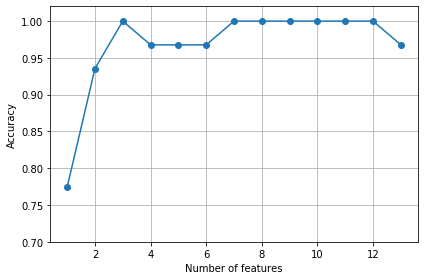

In [38]:
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
plt.show()

특성 개수가 줄었을 때 검증 세트에서 KNN 분류기의 정확도가 향상되었다  
차원의 저주가 감소하기 때문이다  
또 $k$={3,7,8,9,0,11,12}에서 분류기가 100% 정확도를 달성한 것을 볼 수 있다  

가장 작은 개수의 조합(k=3)에서 높은 검증 세트 성능을 내는 특성이 어떤 것인지 확인해 보자

In [39]:
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


이 코드는 sbs.subsets_ 속성의 11번째 위치에 있는 세 개의 특성에 대한 열 인덱스를 얻는다  
이 열 인덱스로부터 판다스 Wine DataFrame의 특성 이름을 출력한다  

이제 원래 테스트 세트에서 KNN분류기의 성능을 평가해보자

In [40]:
knn.fit(X_train_std, y_train)
print('훈련 정확도:', knn.score(X_train_std, y_train))

훈련 정확도: 0.967741935483871


In [41]:
print('테스트 정확도:', knn.score(X_test_std, y_test))

테스트 정확도: 0.9629629629629629


전체 특성 조합을 사용해서 두개의 정확도가 모두 높게 나왔다(=새로운 데이터에도 잘 일반화 될 것이다)  
이제 선택된 세 개의 특성에서 KNN 성능이 얼마나 되는지 확인해 보자  

In [42]:
knn.fit(X_train_std[:, k3], y_train)
print('훈련 정확도:', knn.score(X_train_std[:, k3], y_train))

훈련 정확도: 0.9516129032258065


In [43]:
print('훈련 정확도:', knn.score(X_test_std[:, k3], y_test))

훈련 정확도: 0.9259259259259259


특성 개수를 줄여서 KNN 모델의 성능이 증가하지는 않았지만 데이터셋 크기를 줄였다  
데이터 수집 비용이 높은 실전 애플리케이션에서는 유용할 수 있다  
또 특성 개수를 크게 줄였기 때문에 더 간단한 모델을 얻었고 해석하기도 쉽다  

## 4.6 랜덤 포레스트의 특성 중요도 사용

랜덤 포레스트를 사용하면 앙상블에 참여한 모든 결정 트리에서 계산한 평균적인 불순도 감소로 특성 중요도를 측정할 수 있다  
데이터셋이 선형적으로 구분 가능한지 여부를 가정할 필요가 없다  
편리하게도 사이킷런의 랜덤 포레스트 구현은 특성 중요도 값을 이미 수집하고 있다  

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of Ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


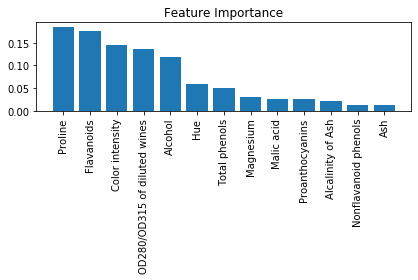

In [46]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                  random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]),
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

코드를 실행하면 Wine 데이터셋 특성의 상대적인 중요도에 따른 순위를 그래프로 그린다  
특성 중요도는 합이 1이 되도록 정규화된 값이다  
이 그래프에서 높은 순위에 위치한 특성 중 두개는 이전 절에서 구현한 SBS 알고리즘으로 선택한 세 개의 특성에 들어있다  
랜덤 포레스트에서 두 개 이상의 특성이 매우 상관관계가 높다면 하나의 튿성은 매우 높은 순위를 갖지만 다른 특성의 정보는 완전히 잡아내지 못할 수 있다  
특성 중요도 값을 해석하는 것보다 모델의 예측 성능에만 관심이 있다면 이 문제는 상관이 없다  

사이킷런의 SElectFormModel은 모델 훈련이 끝난 후 사용자가 지정한 임계 값을 기반으로 특성을 선택한다  
Pipeline의 중간 단계에서 RandomForestClassifier를 특성 선택기로 사용할 때 유용하다  

예를 들어 다음 코드에서는 임계 값을 0.1로 하여 가장 중요한 다섯개의 특성으로 데이터셋을 줄였다  

In [49]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('이 임계 조건을 만족하는 샘플의 수:', X_selected.shape[1])

이 임계 조건을 만족하는 샘플의 수: 5


In [50]:
for f in range(X_selected.shape[1]):
    print("%2d) %-*s %f" % (f + 1,30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
